# Reconocimiento de Microexpresiones a partir de Optical Flows

Las **microexpresiones faciales** son movimientos musculares sutiles y breves, que ocurren involuntariamente y revelan emociones ocultas. Estas expresiones, que suelen durar menos de medio segundo, son extremadamente difíciles de detectar a simple vista, pero contienen información valiosa en contextos como la psicología, la seguridad, o la interacción humano-computadora.

El objetivo de este proyecto es **reconocer microexpresiones faciales** utilizando un conjunto de datos previamente procesado, donde cada muestra ha sido transformada en una imagen **RGB de 28×28 píxeles**, codificando el **flujo óptico** entre el *onset* (inicio del movimiento) y el *apex* (pico máximo de expresión).


### ¿Qué son las Action Units (AUs)?

El reconocimiento de emociones en microexpresiones se puede abordar a través del sistema **Facial Action Coding System (FACS)**, el cual descompone cualquier expresión facial en unidades llamadas **AUs (Action Units)**. Cada AU corresponde a la activación de un grupo específico de músculos faciales. 

Por ejemplo:

- **AU01**: Elevación del entrecejo.
- **AU12**: Elevación de las comisuras (sonrisa).
- **AU04**: Fruncido del entrecejo.




<div align="center">
  <img src="figs/aus-grid.png" alt="Action Unit Reference" width="600"/>
</div>

*Figura: Representación visual de las principales **Action Units (AUs)** del sistema FACS.*


## Prueba de concepto: modelo convolucional básico (`SimpleAUCNN`)

Antes de adoptar una arquitectura más compleja, realizamos una prueba de concepto con una red neuronal convolucional simple. 

El objetivo fue validar si, **incluso con tan pocos datos y entradas tan pequeñas (28×28)**, el modelo era capaz de aprender a predecir **AUs individuales** y no solo emociones globales.

```python
class SimpleAUCNN(nn.Module):
    def __init__(self, num_aus):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_aus)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28→14
        x = self.pool(F.relu(self.conv2(x)))  # 14→7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))  # salida multietiqueta

El modelo demostró ser capaz de aprender señales asociadas a AUs individuales, lo cual valida nuestro enfoque:
<div align="center">
  <img src="figs/loss_acc_plot_epoch.png" width="600"/>
</div>


*Figura: Pérdida y exactitud por época. Se observa una rápida convergencia y buena precisión en validación, aunque con riesgo de sobreajuste.*

## Solución: HTNet para microexpresiones

HTNet (Hierarchical Transformer Network) fue originalmente diseñado para el reconocimiento de expresiones faciales (FER) a partir de imágenes RGB, introduciendo una arquitectura jerárquica que combina la atención **local** y **global**. Su diseño resulta particularmente adecuado para el reconocimiento de microexpresiones por las siguientes razones:

- **Atención local**: HTNet divide el rostro en regiones semánticas (cejas, ojos, nariz, boca, etc.) y aplica *transformers locales* a cada subregión. Esto permite capturar sutiles variaciones intra-regionales, esenciales para microexpresiones.
- **Atención global**: Las representaciones locales se integran mediante un *transformer global*, que modela la estructura facial completa y las relaciones interregionales.
- **Aprendizaje jerárquico estructurado**: La combinación local-global permite modelar tanto detalles finos como patrones globales, siendo útil para identificar expresiones faciales que implican múltiples áreas faciales de manera coordinada.

> Aunque fue entrenado originalmente para tareas de clasificación de emociones (es decir, un problema de **clasificación multicategoría**), hemos adaptado su arquitectura para abordar un problema **multi-etiqueta**, en el cual buscamos predecir la activación simultánea de múltiples Action Units (AUs).

Varios trabajos recientes han explorado el uso de HTNet y arquitecturas jerárquicas similares en el contexto de **microexpresiones faciales**, lo cual respalda su aplicabilidad en este dominio:

- **Zhang et al. (2022)** adaptaron HTNet para analizar secuencias de microexpresiones a partir de videos preprocesados con Optical Flow.
- **Wu et al. (2023)** demostraron que la integración de transformers con flujos ópticos mejora significativamente la detección de microexpresiones sutiles, especialmente en entornos con bajo contraste o ruido.


<div align="center">
  <img src="figs/htnet-architecture.png" width="300"/>
</div>

1. **Patch Embedding:** El modelo recibe como entrada imágenes de flujo óptico de 28×28×3, que codifican de forma compacta la dirección y magnitud del movimiento facial.
Estas imágenes son divididas en subregiones (patches) que se proyectan a un espacio latente mediante convoluciones 1×1.

2. **Transformadores Locales Jerárquicos (L1–L3):** Tres niveles consecutivos de transformers locales capturan las relaciones espaciales dentro de cada subregión facial (como ojos, cejas, boca).
Esto permite que el modelo aprenda patrones locales específicos de AUs, como el levantamiento del párpado (AU5) o el fruncimiento de las cejas (AU4), sin perder resolución contextual.

3. **Operaciones de Agrupamiento (Aggregate Layers):** Después de cada transformer local, se aplica una operación de Aggregate que combina la información y reduce la resolución espacial progresivamente.
Esto crea un embudo jerárquico similar al de una CNN, preservando estructuras relevantes y evitando sobreajuste.

4. **Transformer Global:** Una vez extraídas las representaciones locales, se aplica un transformer global para capturar interacciones entre regiones. Esto es crucial para modelar expresiones que involucran la coordinación de múltiples AUs simultáneamente (e.g., AU6+AU12 en una sonrisa auténtica).

5. **MLP Head Multi-etiqueta:** La salida del modelo pasa por una capa LayerNorm, seguida de MeanPool global y una capa Fully Connected con activación Sigmoid.
Esto permite generar una probabilidad independiente por cada AU activa, lo que lo convierte en un modelo multi-label en lugar de una simple clasificación categórica.

```python
class HTNet(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, heads, num_hierarchies, block_repeats):
        super().__init__()
        # Embedding de parches
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=patch_size, p2=patch_size),
            nn.Conv2d(3 * patch_size**2, dim, 1)
        )

        # Construcción de jerarquías (de coarse a fine)
        self.layers = nn.ModuleList()
        for level in reversed(range(num_hierarchies)):
            block_size = 2 ** level
            transformer = Transformer(dim, seq_len=(image_size // patch_size // block_size)**2,
                                      depth=block_repeats, heads=heads)
            aggregate = nn.Identity() if level == 0 else Aggregate(dim, dim)
            self.layers.append(nn.ModuleList([transformer, aggregate]))

        # Clasificación multilabel sin sigmoid
        self.mlp_head = nn.Sequential(
            LayerNorm(dim),
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        for level, (transformer, aggregate) in enumerate(self.layers[::-1]):
            block_size = 2 ** level
            x = rearrange(x, 'b c (b1 h) (b2 w) -> (b b1 b2) c h w', b1=block_size, b2=block_size)
            x = transformer(x)
            x = rearrange(x, '(b b1 b2) c h w -> b c (b1 h) (b2 w)', b1=block_size, b2=block_size)
            x = aggregate(x)
        return self.mlp_head(x)
```

In [27]:
from Model import HTNet
import torch

device = torch.device("cpu")

model = HTNet(
    num_classes=25,
    image_size=28,
    patch_size=7,
    dim=64,
    heads=4,
    num_hierarchies=2,
    block_repeats=2
).to(device)

## Adaptación del Modelo HTNet para Detección Multietiqueta de AUs

Partimos del trabajo propuesto por Chen et al. (2023) en *HTNet: Hierarchical Transformer Networks for Micro-Expression Recognition* (arXiv:2307.14637), el cual introduce una arquitectura basada en Transformers jerárquicos para el reconocimiento de microexpresiones faciales a través de la detección de Action Units (AUs) utilizando optical flow como entrada y etiquetas por AU.

### Cambios y aportes principales en nuestra implementación

- **Salida explícitamente multietiqueta**: Mientras que el modelo original trata la tarea como una clasificación por expresión o conjunto de AUs activas, nuestra variante **modela cada AU como una categoría binaria independiente**, adaptando la salida final a `logits (batch, num_AUs)` sin softmax, utilizando BCEWithLogitsLoss con `pos_weight` ajustado.

- **Cuerpo más modular**: Reescribimos la arquitectura con componentes desacoplados y documentados (e.g., atención espacial, `LayerNorm` por canal, `Aggregate`, `FeedForward` convolucional), facilitando su reutilización en otros contextos.

- **Entrenamiento directo con etiquetas por AU**: En lugar de depender de clases compuestas (como “feliz”, “sorpresa”), utilizamos etiquetas explícitas para cada AU como columnas individuales en el dataset, lo que permite evaluar de forma granular el rendimiento de detección de cada unidad facial.

- **Head MLP modificado**: La cabeza de clasificación se ajustó para tareas multilabel, usando reducción espacial (`Reduce`) y eliminación de activaciones finales, dejando la activación a cargo de la función de pérdida externa.

- **Evaluación con métricas multilabel**: Incorporamos cálculo de F1 y UAR por AU, evaluando el modelo como un clasificador binario por cada etiqueta (AU) en lugar de una única predicción multicategoría.

Este enfoque permite usar HTNet no solo para clasificación general de expresiones, sino también como una herramienta de análisis facial más detallado, orientada a tareas como *pain detection*, *lie detection*, y *emoción compuesta*, donde es crucial detectar activaciones específicas de AUs.

## Preprocesamiento de etiquetas de AUs desde anotaciones FACS

Para enriquecer nuestro dataset con etiquetas más precisas y detalladas, realizamos un proceso de extracción y codificación de las **Action Units (AUs)** a partir del archivo anotado del dataset SAMM, específicamente desde el Excel `SAMM_Micro_FACS_Codes_v2.xlsx`. Dicho archivo contiene anotaciones en formato FACS para cada microexpresión, expresadas como cadenas alfanuméricas que indican la AU y su intensidad.

### Fuente y estructura de los datos

La hoja de Excel incluye, entre otros campos:
- `Subject`: código del sujeto.
- `Filename`: nombre del clip de video correspondiente.
- `Action Units`: anotaciones tipo `"1A+2B+4C"` que combinan el número de AU y una letra que indica intensidad.

El CSV base (`samm_multilabel_AU.csv`) que usamos como plantilla contiene una fila por muestra de imagen (frame) y columnas binarias `AU_01`, `AU_02`, ..., las cuales inicialmente estaban vacías o contenían valores por defecto.

### Objetivo del preprocesamiento

1. Parsear las anotaciones tipo `"4B+7C"` y convertirlas en valores numéricos.
2. Mapear estas intensidades a valores continuos entre 0.2 y 1.0 según la siguiente tabla:

    | Sufijo FACS | Intensidad numérica |
    |-------------|---------------------|
    | A           | 0.2                 |
    | B           | 0.4                 |
    | C           | 0.6                 |
    | D           | 0.8                 |
    | E (o vacío) | 1.0                 |

3. Asociar estas etiquetas con los frames correspondientes en el CSV, utilizando como clave `(Subject, Filename)`.


In [28]:
import pandas as pd

samm_expanded_df = pd.read_csv('samm_multilabel_au_expanded.csv')

samm_expanded_df.head(5)

,dataset,sub,filename_o,label,apex,imagename,sub_filename,Filename,Action Units,AU_04,...,AU_09,AU_61,AU_14,AU_10,AU_01,AU_08,AU_39,AU_13,AU_38,AU_56
0,samm,sub006,006_1_6,0,7197,datasets/SAMM_Normalized_TM/sub006/006_1_6/006...,sub006_006_1_6.png,006_1_6,4+7+43,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,samm,sub006,006_2_4,0,217,datasets/SAMM_Normalized_TM/sub006/006_2_4/006...,sub006_006_2_4.png,006_2_4,4+7,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,samm,sub006,006_3_4,0,668,datasets/SAMM_Normalized_TM/sub006/006_3_4/006...,sub006_006_3_4.png,006_3_4,15A+17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,samm,sub006,006_3_5,0,1829,datasets/SAMM_Normalized_TM/sub006/006_3_5/006...,sub006_006_3_5.png,006_3_5,25+26,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,samm,sub006,006_5_10,0,1465,datasets/SAMM_Normalized_TM/sub006/006_5_10/00...,sub006_006_5_10.png,006_5_10,L20+21,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import GroupShuffleSplit
from au_dataset import AUOpticalFlowDataset

# Transformaciones de imagen
transform = T.Compose([ 
    T.ToTensor(),
])

# Rutas
csv_path = "samm_multilabel_au_expanded.csv"
images_folder = "dataset/SAMM_FLOWS"

# Dataset completo
dataset = AUOpticalFlowDataset(
    csv_path=csv_path,
    images_folder=images_folder,
    transform=transform
)

# Obtener grupos (sujetos) desde el DataFrame interno del dataset
df = dataset.data
groups = df["sub"].values  # Agrupamos por sujeto

# Split usando GroupShuffleSplit (80% train, 20% val)
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=groups))

# Subsets separados
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

def multilabel_metrics(y_true, y_pred_logits, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)  # ⬅️ Aquí fuerza a binario entero
    y_prob = 1 / (1 + np.exp(-y_pred_logits))  # aplica sigmoid
    y_pred_bin = (y_prob > threshold).astype(int)

    # Verificación de forma
    if y_pred_bin.shape != y_true.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred_bin {y_pred_bin.shape}")

    return {
        "f1": f1_score(y_true, y_pred_bin, average='macro', zero_division=0),
        "precision": precision_score(y_true, y_pred_bin, average='macro', zero_division=0),
        "recall": recall_score(y_true, y_pred_bin, average='macro', zero_division=0),
    }

In [31]:
import torch
import torch.nn as nn
import numpy as np
import copy
import torchvision.transforms as T
import wandb

from au_dataset import AUOpticalFlowDataset

# === Inicialización wandb ===
wandb.init(project="microexpresiones-au", name="HTNet-MultiLabel", config={
    "epochs": 50,
    "batch_size": 16,
    "lr": 1e-4,
    "threshold": 0.1,
    "loss_fn": "BCELoss",
    "optimizer": "Adam"
})
config = wandb.config

# === Device y parámetros ===
device = torch.device("cpu")
num_epochs = config.epochs
patience = 1

# === Dataset y Transformaciones ===
dataset = AUOpticalFlowDataset(
    csv_path="samm_multilabel_au_expanded.csv",
    images_folder="dataset/SAMM_FLOWS",
    transform=T.Compose([T.ToTensor()])
)

# === Cálculo de pos_weight (aunque no se usa en BCELoss directamente) ===
print("📊 Calculando pos_weight dinámico...")
all_labels = [dataset[i][1] for i in range(len(dataset))]  # Extraer solo labels
labels_tensor = torch.stack(all_labels)
au_counts = labels_tensor.sum(dim=0)
total = labels_tensor.shape[0]
pos_weight = (total - au_counts) / (au_counts + 1e-6)

# === Criterio de pérdida ===
criterion = nn.BCELoss()

# === Optimizador ===
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

# === Early Stopping variables ===
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_losses = []
val_losses = []

# === Entrenamiento ===
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validación ===
    model.eval()
    val_running_loss = 0.0
    all_targets = []
    all_preds   = []
    all_probs   = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # logits
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()

            probs = torch.sigmoid(outputs)  # probabilidades
            preds = (probs > config.threshold).int()

            all_targets.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

            # Convierte listas de tensores a arrays
            y_true = torch.cat(all_targets, dim=0).numpy()
            y_logits = torch.cat(all_preds, dim=0).numpy()  # ← ¡Ojo! aquí deberías guardar logits, no predicciones binarizadas

    # Si guardaste los logits (mejor práctica):
    y_pred_logits = torch.cat(all_probs, dim=0).numpy()

    metrics = multilabel_metrics(y_true, y_pred_logits, threshold=config.threshold)

    print(f"📈 F1: {metrics['f1']:.4f} | Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f}")


    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # === Logs a wandb ===
    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "epoch": epoch + 1,
        "au_probs_hist": wandb.Histogram(torch.cat(all_probs).numpy())
    })

    # Ejemplo de predicción
    wandb.log({
        "sample_probs": wandb.Histogram(all_probs[0][0].numpy()),
        "sample_preds": wandb.Histogram(all_preds[0][0].numpy())
    })

    print(f"📊 Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # === Early Stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_without_improvement = 0
        print("✅ Mejora detectada: modelo guardado.")
    else:
        epochs_without_improvement += 1
        print(f"⏳ Sin mejora en {epochs_without_improvement} épocas.")
        if epochs_without_improvement >= patience:
            print("🛑 Early stopping activado.")
            break

# === Guardado de modelo final ===
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_htnet_model.pth")
wandb.save("best_htnet_model.pth")
wandb.finish()
print("💾 Modelo final guardado como 'best_htnet_model.pth'")

📊 Calculando pos_weight dinámico...
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 1/50 - Train Loss: 0.5427 - Val Loss: 0.3693
✅ Mejora detectada: modelo guardado.
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 2/50 - Train Loss: 0.3355 - Val Loss: 0.2997
✅ Mejora detectada: modelo guardado.
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 3/50 - Train Loss: 0.2890 - Val Loss: 0.2712
✅ Mejora detectada: modelo guardado.
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 4/50 - Train Loss: 0.2677 - Val Loss: 0.2557
✅ Mejora detectada: modelo guardado.
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 5/50 - Train Loss: 0.2551 - Val Loss: 0.2438
✅ Mejora detectada: modelo guardado.
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 6/50 - Train Loss: 0.2433 - Val Loss: 0.2339
✅ Mejora detectada: modelo guardado.
📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 7/50 - Train Loss: 0.2339 - Val Loss: 0.2262
✅ Mejora detectada: m

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


📈 F1: 0.0561 | Precision: 0.0314 | Recall: 0.3200
📊 Epoch 31/50 - Train Loss: 0.1494 - Val Loss: 0.1605
⏳ Sin mejora en 1 épocas.
🛑 Early stopping activado.


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
train_loss,0.14937
val_loss,0.16049


💾 Modelo final guardado como 'best_htnet_model.pth'


In [34]:
model.eval()

HTNet(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (p1 p2 c) h w', p1=7, p2=7)
    (1): Conv2d(147, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (layers): ModuleList(
    (0): ModuleList(
      (0): Transformer(
        (layers): ModuleList(
          (0-1): 2 x ModuleList(
            (0): PreNorm(
              (norm): LayerNorm()
              (fn): Attention(
                (attend): Softmax(dim=-1)
                (dropout): Dropout(p=0.0, inplace=False)
                (to_qkv): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (to_out): Sequential(
                  (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
                  (1): Dropout(p=0.0, inplace=False)
                )
              )
            )
            (1): PreNorm(
              (norm): LayerNorm()
              (fn): FeedForward(
                (net): Sequential(
                  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [45]:
model.eval()
for idx in range(10):  # probar primeros 10
    image_tensor, label_tensor = dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        predicted = (output[0] > 0.12).float()  # ⬅️ nuevo umbral aquí
    
    print(f"\n🔍 Imagen {idx}")
    print("Predichas:")
    for i, val in enumerate(predicted):
        if val == 1.0:
            print(f" AU: {dataset.au_columns[i]}")
    print("Reales:")
    for i, val in enumerate(label_tensor):
        if val == 1.0:
            print(f" AU: {dataset.au_columns[i]}")


🔍 Imagen 0
Predichas:
 AU: AU_04
 AU: AU_07
Reales:
 AU: AU_04
 AU: AU_07
 AU: AU_43

🔍 Imagen 1
Predichas:
 AU: AU_04
 AU: AU_07
Reales:
 AU: AU_04
 AU: AU_07

🔍 Imagen 2
Predichas:
 AU: AU_12
Reales:
 AU: AU_17

🔍 Imagen 3
Predichas:
Reales:
 AU: AU_25
 AU: AU_26

🔍 Imagen 4
Predichas:
Reales:
 AU: AU_20
 AU: AU_21

🔍 Imagen 5
Predichas:
 AU: AU_04
 AU: AU_07
Reales:
 AU: AU_04

🔍 Imagen 6
Predichas:
 AU: AU_04
 AU: AU_07
Reales:
 AU: AU_05

🔍 Imagen 7
Predichas:
 AU: AU_07
Reales:
 AU: AU_20

🔍 Imagen 8
Predichas:
 AU: AU_07
 AU: AU_12
 AU: AU_14
Reales:
 AU: AU_24

🔍 Imagen 9
Predichas:
 AU: AU_07
 AU: AU_24
 AU: AU_12
Reales:
 AU: AU_26


In [46]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for image_tensor, label_tensor in dataset:
        input_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(input_tensor)

        probs = torch.sigmoid(output[0]).cpu().numpy()
        binarized = (probs > 0.5).astype(int)  # ⚠️ <- Aquí se asegura el formato adecuado

        y_true.append(label_tensor.numpy())
        y_pred.append(binarized)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

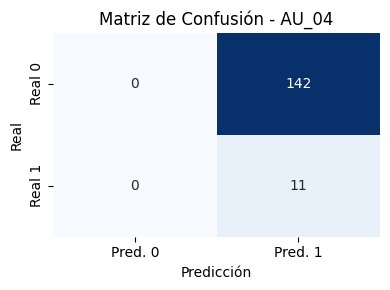

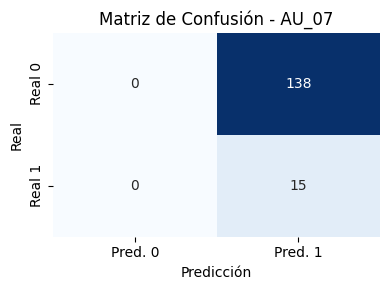

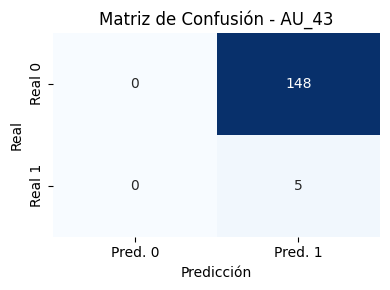

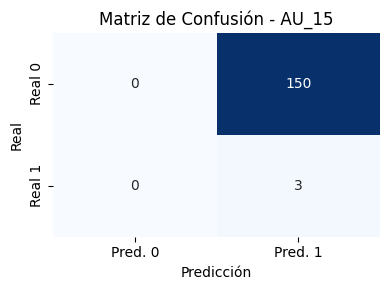

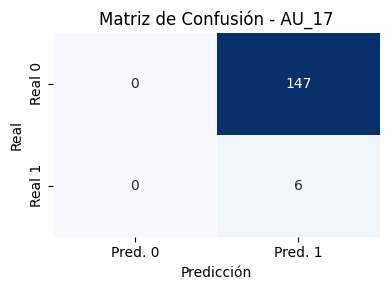

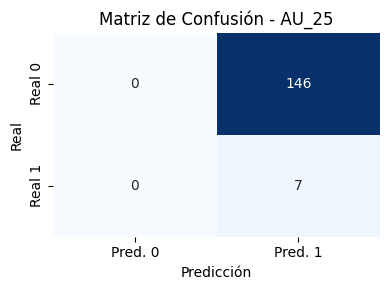

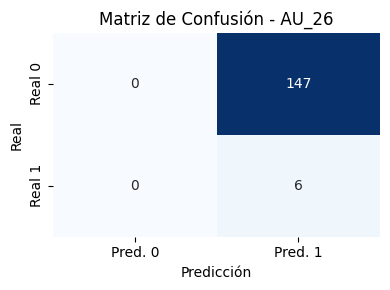

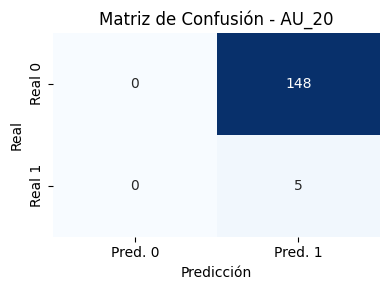

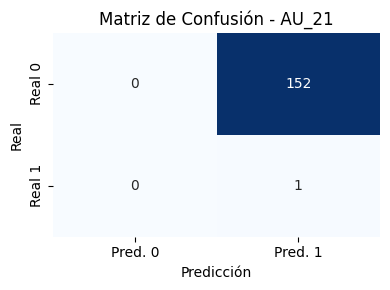

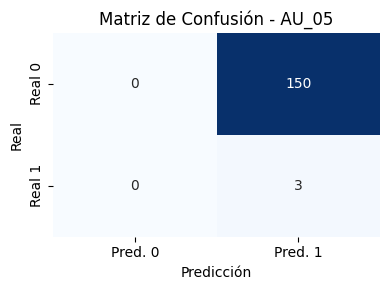

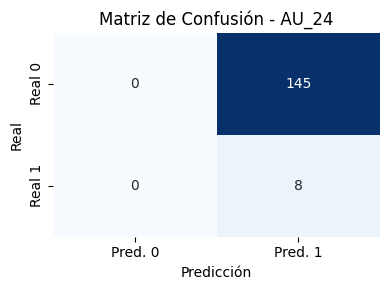

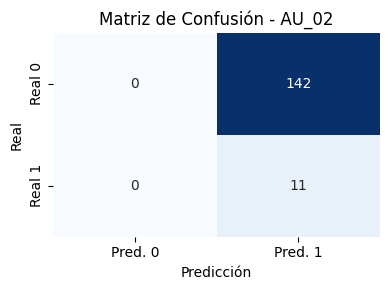

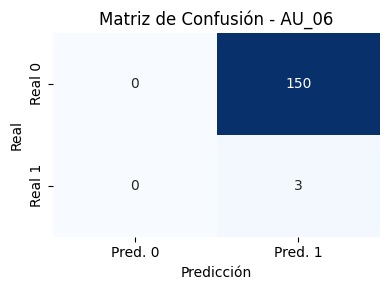

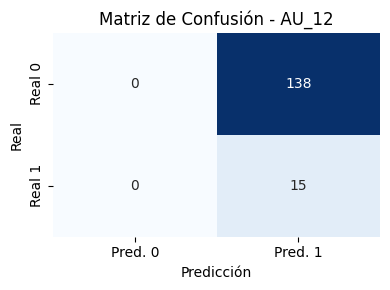

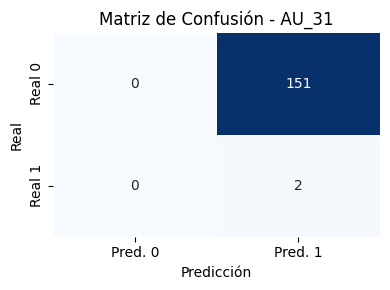

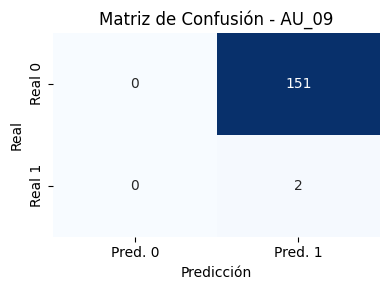

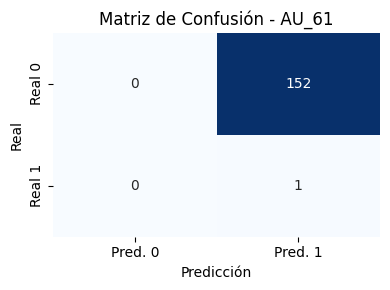

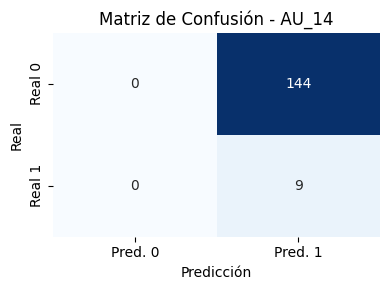

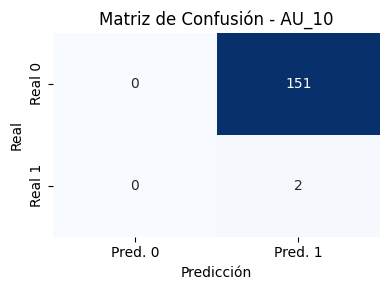

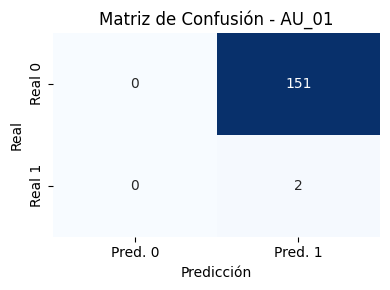

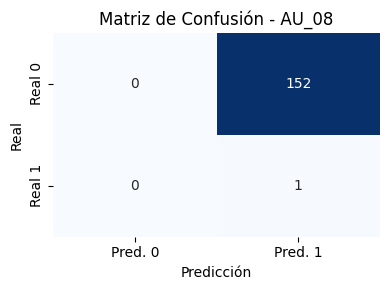

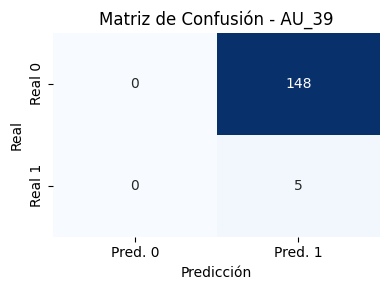

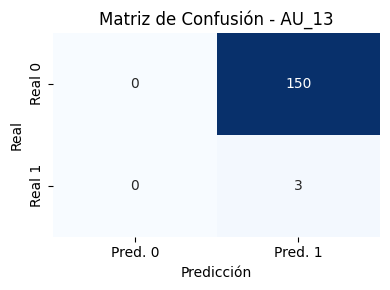

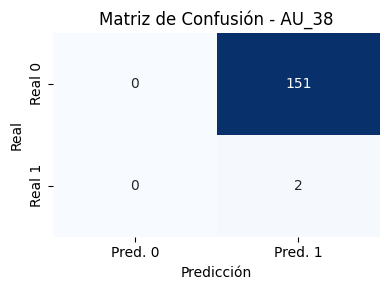

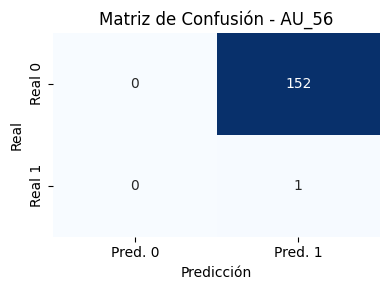

In [48]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).astype(int)
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

for i, au in enumerate(dataset.au_columns):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred. 0", "Pred. 1"],
                yticklabels=["Real 0", "Real 1"])
    plt.title(f"Matriz de Confusión - {au}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()